In [8]:
pip install --upgrade pip

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/8a/6a/19e9fe04fca059ccf770861c7d5721ab4c2aebc539889e97c7977528a53b/pip-24.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
    --------------------------------------- 0.0/2.1 MB 487.6 kB/s eta 0:00:05
   - -------------------------------------- 0.1/2.1 MB 744.7 kB/s eta 0:00:03
   ---- ----------------------------------- 0.3/2.1 MB 1.6 MB/s eta 0:00:02
   --------- ------------------------------ 0.5/2.1 MB 2.5 MB/s eta 0:00:01
   ----------- ---------------------------- 0.6/2.1 MB 2.8 MB/s eta 0:00:01
   ----------- ---------------------------- 0.6/2.1 MB 2.8 MB/s eta 0:00:01
   ---------------------- ----------------- 1.2/2.1 MB 3.2 MB/s eta 0:00:01
   ----------------------- ---------------- 1.2/2.1 MB 3.4 MB/s eta 0:00:01
   ------------------------------ --------- 1.6/2.1 MB 3.7 M

In [1]:
pip install opencv-contrib-python

  Using cached opencv_contrib_python-4.9.0.80-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_contrib_python-4.9.0.80-cp37-abi3-win_amd64.whl (45.3 MB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from cv2 import dnn_superres
import os


In [25]:
def compress_image(image, compression_quality):
    # Convert image to JPEG format with compression quality
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), compression_quality]
    _, compressed_image = cv2.imencode('.jpg', image, encode_param)
    # Decode the compressed image
    decompressed_image = cv2.imdecode(compressed_image, 1)
    return decompressed_image

In [26]:
def getSize(path):
    image_size_bytes = os.path.getsize(path)
    # Convert bytes to kilobytes
    image_size_kb = image_size_bytes / 1024.0
    return image_size_kb


### Lossy Compressing the image

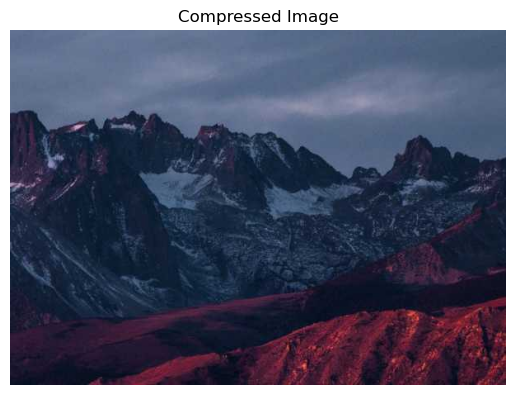

Size of the Compressed image :  306.0166015625  kB
Size of the Original image :  430.79296875  kB


In [33]:
image_path = 'images/mountains.png'
input_image = cv2.imread(image_path)

compressed_image = compress_image(input_image, compression_quality=50)

# Display or save the compressed image as needed
plt.imshow(cv2.cvtColor(compressed_image,cv2.COLOR_RGB2BGR))
plt.axis('off')
plt.title("Compressed Image")
plt.show()

compressed_image_path = './compressed_images/mountains_compressed.png'
cv2.imwrite(compressed_image_path,compressed_image)

image_size_kb1 = getSize(compressed_image_path)
image_size_kb2 = getSize(image_path)
print("Size of the Compressed image : ",image_size_kb1," kB")
print("Size of the Original image : ",image_size_kb2," kB")


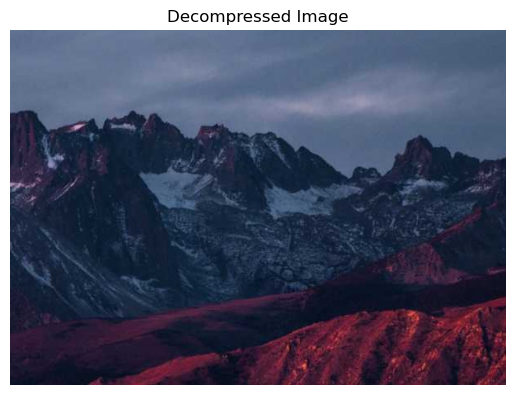

In [34]:

# Create an SR object
sr = dnn_superres.DnnSuperResImpl_create()

# Read image
# image = cv2.imread('./compressed_images/mountains_compressed.png')
image = cv2.imread('./compressed_images/mountains_compressed.png')

# Read the desired model
path = "./models/ESPCN_x2.pb"
sr.readModel(path)

# Set the desired model and scale to get correct pre- and post-processing
sr.setModel("espcn", 2)

# Upscale the image
result = sr.upsample(image)
result = cv2.resize(result,(image.shape[1],image.shape[0]))
# Save the image
cv2.imwrite("./upscaled_mountains.png", result)

plt.imshow(cv2.cvtColor(result,cv2.COLOR_RGB2BGR))
plt.axis('off')
plt.title('Decompressed Image')
plt.show()


In [12]:
# print(result.shape)
print(input_image.shape)
print(image.shape)

(431, 602, 3)
(431, 602, 3)


## Wrapping the whole process within a class

In [67]:
class SuperCompression:
    def __init__(self,model_name,upscale_factor,model_path):
        self.model_name = model_name
        self.uf = upscale_factor
        self.model_path = model_path
        self.initializeModel()
        
    def initializeModel(self):
        self.sr = dnn_superres.DnnSuperResImpl_create()
        self.sr.readModel(self.model_path)
        self.sr.setModel(self.model_name,self.uf)
        
    # image : cv2 Image, image_quality : int in range[0-100]
    def compressImage(self,image_path,image_quality):
        image = cv2.imread(image_path)
        self.original_image = image
        self.original_shape = image.shape
        encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), image_quality]
        _, compressed_image = cv2.imencode('.jpg', image, encode_param)
        # Decode the compressed image
        decoded_image = cv2.imdecode(compressed_image, 1)
        self.compressed_image = decoded_image
        return decoded_image
    
    # returns the size in kb of a file
    def getSize(self,path):
        image_size_bytes = os.path.getsize(path)
        # Convert bytes to kilobytes
        image_size_kb = image_size_bytes / 1024.0
        return image_size_kb

    def decompressImage(self,image_path,k):
        img = cv2.imread(image_path)
        result = self.sr.upsample(img)
        result = cv2.resize(result,(self.original_shape[1],self.original_shape[0]))
        print("Iteration 1 : Done")
        
        # doing k times upscaling
        for i in range(k-1):
            result = self.sr.upsample(result)
            result = cv2.resize(result,(self.original_shape[1],self.original_shape[0]))
            print("Iteration",i+2,": Done")
            
        self.decompressed_image = result
        return result
    
    def saveImage(self,img,image_path):
        cv2.imwrite(image_path,img)
    
    
            

In [75]:
model_name = "edsr"
model_path = "./models/EDSR_x4.pb"
upscale_factor = 4
image_path = "./images/mountains.png"
compressed_image_path = "./compressed_images/mountains_c.png"
decompressed_image_path = "./mountains_d.png"
image_quality = 70
k = 10

sc = SuperCompression(model_name,upscale_factor,model_path)
compressed_image = sc.compressImage(image_path,image_quality)
sc.saveImage(compressed_image,compressed_image_path)
decompressed_image = sc.decompressImage(compressed_image_path,k)
sc.saveImage(decompressed_image,decompressed_image_path)


# mountain image takes a long time to run, change to butterfly image to observe quick results
# Problem :-
# On compressing the butterfly.png, its size increases??

Iteration 1 : Done
Iteration 2 : Done
Iteration 3 : Done
Iteration 4 : Done
Iteration 5 : Done
Iteration 6 : Done
Iteration 7 : Done
Iteration 8 : Done
Iteration 9 : Done
Iteration 10 : Done
